In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('airline-passenger-traffic.csv', header = None)

In [3]:
df.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns = ['Month','Passengers']
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [5]:
#Convert into datetime
df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')

In [6]:
df = df.set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


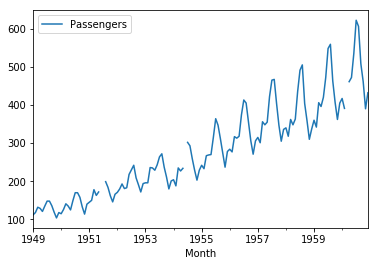

In [7]:
df.plot()
plt.show()

## Missing value imputation

In [8]:
#Mean IMputation
df = df.assign(Passengers_Mean_Imputation = df.Passengers.fillna(df.Passengers.mean()))

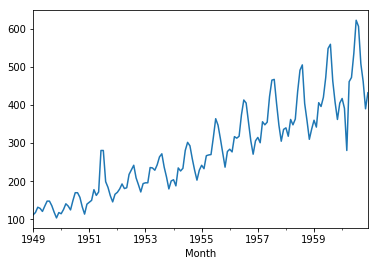

In [9]:
df['Passengers_Mean_Imputation'].plot()

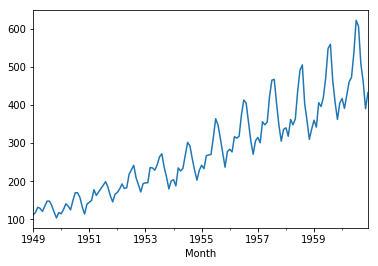

In [10]:
#Linear Interpolation
df = df.assign(Passengers_Linear_Interpolation = df.Passengers.interpolate(method = 'linear'))
df['Passengers_Linear_Interpolation'].plot()

# Outlier treatment

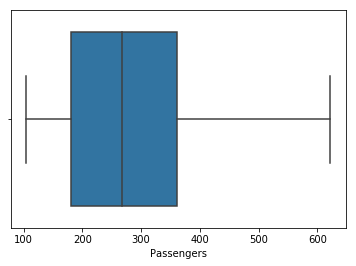

In [11]:
sns.boxplot(df['Passengers'], whis = 1.5)

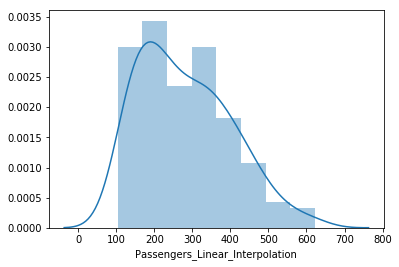

In [12]:
#PLotting histogram to see outliers
sns.distplot(df['Passengers_Linear_Interpolation'])

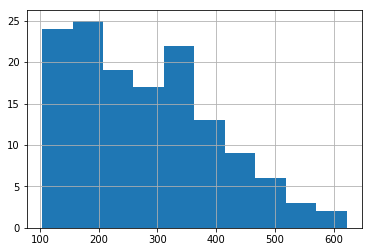

In [13]:
df.Passengers.hist()

### Train test

In [14]:
train_len= 120
data = df[['Passengers_Linear_Interpolation']]
train = data[0:train_len]
test = data[train_len:]

## Naive Method

In [15]:
y_hat_naive = test.copy()
y_hat_naive['Naive_Forecast'] = train['Passengers_Linear_Interpolation'][train_len-1]

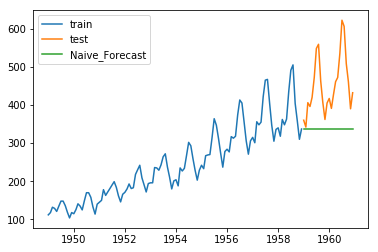

In [16]:
plt.plot(train['Passengers_Linear_Interpolation'], label = 'train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'test')
plt.plot(y_hat_naive['Naive_Forecast'], label = 'Naive_Forecast')
plt.legend(loc = 'best')
plt.show()

## Simple Average Method

In [17]:
y_hat_naive['SAM_Forecast'] = train['Passengers_Linear_Interpolation'].mean()

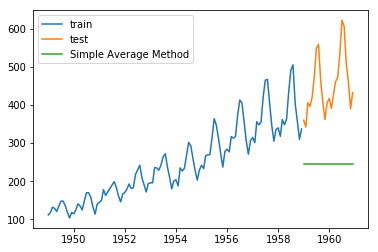

In [18]:
plt.plot(train['Passengers_Linear_Interpolation'], label = 'train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'test')
plt.plot(y_hat_naive['SAM_Forecast'], label = 'Simple Average Method')
plt.legend(loc = 'best')
plt.show()

## Calculate RMSE and MAPE

In [19]:
rmse = np.sqrt(mean_squared_error(test['Passengers_Linear_Interpolation'], y_hat_naive['Naive_Forecast'])).round(0)

In [20]:
mape =np.round(np.mean(abs((test['Passengers_Linear_Interpolation'] -  y_hat_naive['Naive_Forecast'])/test['Passengers_Linear_Interpolation'])) * 100,2)

In [21]:
result = pd.DataFrame({'Method':['Naive'],'RMSE':[rmse], 'MAPE': [mape]})
result

,Method,RMSE,MAPE
0,Naive,138.0,23.63


## SimpleMoving average

In [22]:
y_hat_sma = df.copy()
roling_window = 12
y_hat_sma['sma_forecast'] = df['Passengers_Linear_Interpolation'].rolling(roling_window).mean()
y_hat_sma.tail()

,Passengers,Passengers_Mean_Imputation,Passengers_Linear_Interpolation,sma_forecast
Month,,,,
1960-08-01,606.0,606.0,606.0,463.916667
1960-09-01,508.0,508.0,508.0,467.666667
1960-10-01,461.0,461.0,461.0,472.166667
1960-11-01,390.0,390.0,390.0,474.500000
1960-12-01,432.0,432.0,432.0,476.750000


In [23]:
# Chaging the test values as in test w were not having the daa provided
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

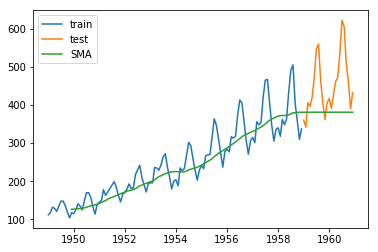

In [24]:
plt.plot(train['Passengers_Linear_Interpolation'], label = 'train')
plt.plot(test['Passengers_Linear_Interpolation'], label= 'test')
plt.plot(y_hat_sma['sma_forecast'], label= 'SMA')
plt.legend(loc = 'best')
plt.show()

## BOX COX Transformation

In [25]:
from scipy.stats import boxcox

In [26]:
data_boxcox = pd.Series(boxcox(df['Passengers_Linear_Interpolation'], lmbda = 0), index = data.index)

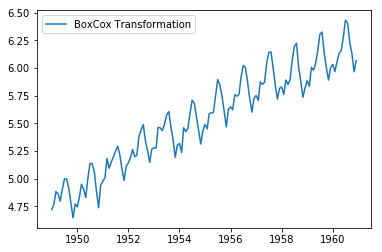

In [27]:
plt.plot(data_boxcox, label = 'BoxCox Transformation')
#plt.plot(df['Passengers_Linear_Interpolation'], label = 'Original Data')
plt.legend(loc = 'best')
plt.show()

## Differencing

In [28]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data.index)


In [29]:
 data_boxcox_diff.dropna(inplace = True) # First value will be NA 

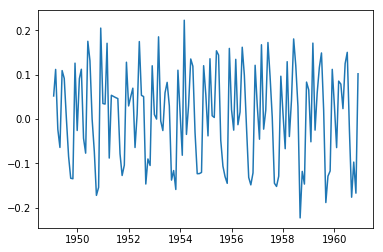

In [30]:
plt.plot(data_boxcox_diff)

## Split into train and test the transformd data

In [51]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## AutoRegression Model

In [52]:
from statsmodels.tsa.arima_model import ARIMA

In [53]:
model =  ARIMA(train_data_boxcox_diff, order = (1,0,0))
model_fit = model.fit()
model_fit.params

C:\Users\Casterwill\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Casterwill\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


const      0.009477
ar.L1.y    0.183116
dtype: float64

## Simple Exponential Smoothing

In [31]:
daily = pd.read_csv('Daily.csv')

In [32]:
daily.drop(columns = ['Date'], inplace = True)

In [33]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [34]:
train = daily[:511]
test = daily[511:]

In [35]:
model = SimpleExpSmoothing(train['Temperature(Min)'])
model_fit = model.fit(smoothing_level = .2, optimized = False)

In [36]:
test['Predicted'] = model_fit.forecast(len(test))

C:\Users\Casterwill\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
rmse_ses = np.sqrt(mean_squared_error(test['Temperature(Min)'],test['Predicted']))

In [38]:
rmse_ses

3.5560737695562894

In [39]:
ques = pd.read_csv('exchange-rate-twi.csv')

In [40]:
ques.head()

,Month,Exchange Rate TWI
0,1,100.0
1,2,99.6
2,3,99.4
3,4,99.1
4,5,99.2


In [41]:
ques = ques.drop(columns = ['Month'])

In [42]:
ques['SMA'] = ques['Exchange Rate TWI'].rolling(6).mean()
ques['SMA'][212:] = ques['SMA'][211]

In [43]:
train_ = ques[:212]
test_ = ques[212:]

In [44]:
y_hat = test_.copy()
y_hat['Naive'] =  train_['Exchange Rate TWI'][len(train_)-1]
y_hat['SAM'] = np.mean(train_['Exchange Rate TWI'])

In [45]:
rmse = np.sqrt(mean_squared_error(test_['Exchange Rate TWI'], y_hat['SMA'])).round(2)
mape =np.round(np.mean(abs((test_['Exchange Rate TWI'] -  y_hat['SMA'])/test_['Exchange Rate TWI'])) * 100,2)

In [46]:
rmse,mape

(4.9, 7.13)

In [47]:
rmse,mape

(4.9, 7.13)

In [48]:
rmse = np.sqrt(mean_squared_error(test_['Exchange Rate TWI'], y_hat['Naive'])).round(2)
mape =np.round(np.mean(abs((test_['Exchange Rate TWI'] -  y_hat['Naive'])/test_['Exchange Rate TWI'])) * 100,2)

In [49]:
from statsmodels.tsa.stattools import adfuller
ad_test = adfuller(ques['Exchange Rate TWI'])

In [50]:
from statsmodels.tsa.stattools import kpss
kpss_tst = kpss(ques['Exchange Rate TWI'])
kpss_tst

C:\Users\Casterwill\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(1.7258967599333663,
 0.01,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})